In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from matplotlib import rc
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from matplotlib.ticker import MaxNLocator
import scipy.signal
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [24]:
datapath = '/mnt/ssd/workspace/stability/MLstability/training_data/'
dset = 'resonant/'
features = 'ressummaryfeaturesxgbNorbits10000.0Nout1000/'
dataset = pd.read_csv(datapath+dset+features+'trainingdata.csv', index_col = 0)
print(dataset.columns.values)

['Zcross12' 'Zcross13' 'Zcross23' 'maxj' 'maxk' 'maxi1' 'maxi2'
 'maxstrength' 'secondres' 'EMmed12' 'EMmax12' 'EMdrift12'
 'capseculartscale12' 'EMdetrendedstd12' 'EMrollingstd12' 'DiffcoeffEM12'
 'medvarEM12' 'Zmed12' 'Zmax12' 'Zdetrendedstd12' 'Zrollingstd12'
 'DiffcoeffZ12' 'medvarZ12' 'Zcomdrift12' 'Zcomrollingstd12'
 'phiZcomdrift12' 'phiZcomrollingstd12' 'Zstardrift12' 'Zstarrollingstd12'
 'Zcosphistd12' 'medZcosphi12' 'EMmed23' 'EMmax23' 'EMdrift23'
 'capseculartscale23' 'EMdetrendedstd23' 'EMrollingstd23' 'DiffcoeffEM23'
 'medvarEM23' 'Zmed23' 'Zmax23' 'Zdetrendedstd23' 'Zrollingstd23'
 'DiffcoeffZ23' 'medvarZ23' 'Zcomdrift23' 'Zcomrollingstd23'
 'phiZcomdrift23' 'phiZcomrollingstd23' 'Zstardrift23' 'Zstarrollingstd23'
 'Zcosphistd23' 'medZcosphi23' 'tlyap']


In [25]:
labels = pd.read_csv(datapath+dset+features+'labels.csv', index_col=0)
labels.tail()

,runstring,instability_time,shadow_instability_time,Stable
9994,0009995.bin,9.990000e+08,9.990000e+08,True
9995,0009996.bin,3.814426e+06,6.124299e+06,False
9996,0009997.bin,1.498363e+04,3.320307e+03,False
9997,0009998.bin,9.419807e+05,8.353625e+05,False
9998,0009999.bin,1.895071e+07,2.047024e+07,False


In [26]:
def takeone(row):
    s = '12' if row['Zcross12'] < row['Zcross23'] else '23'
    row['EMmed'] = row['EMmed'+s]
    row['EMmax'] = row['EMmax'+s]
    row['EMdrift'] = row['EMdrift'+s]
    row['capseculartscale'] = row['capseculartscale'+s]
    row['EMdetrendedstd'] = row['EMdetrendedstd'+s]
    row['EMrollingstd'] = row['EMrollingstd'+s]
    row['DiffcoeffEM'] = row['DiffcoeffEM'+s]
    row['Zcomdrift'] = row['Zcomdrift'+s]
    row['Zcomrollingstd'] = row['Zcomrollingstd'+s]
    row['phiZcomdrift'] = row['phiZcomdrift'+s]
    row['phiZcomrollingstd'] = row['phiZcomrollingstd'+s]
    row['Zstardrift'] = row['Zstardrift'+s]
    row['Zstarrollingstd'] = row['Zstarrollingstd'+s]
    row['Zcosphistd'] = row['Zcosphistd'+s]
    row['medZcosphi'] = row['medZcosphi'+s]
    return row

In [27]:
%%time
dataset = dataset.apply(takeone, axis=1)
print(dataset.shape)
dataset.head()

(9999, 69)
CPU times: user 1min 59s, sys: 1.3 s, total: 2min 1s
Wall time: 2min 1s


In [28]:
dataset.columns.values

array(['Zcross12', 'Zcross13', 'Zcross23', 'maxj', 'maxk', 'maxi1',
       'maxi2', 'maxstrength', 'secondres', 'EMmed12', 'EMmax12',
       'EMdrift12', 'capseculartscale12', 'EMdetrendedstd12',
       'EMrollingstd12', 'DiffcoeffEM12', 'medvarEM12', 'Zmed12',
       'Zmax12', 'Zdetrendedstd12', 'Zrollingstd12', 'DiffcoeffZ12',
       'medvarZ12', 'Zcomdrift12', 'Zcomrollingstd12', 'phiZcomdrift12',
       'phiZcomrollingstd12', 'Zstardrift12', 'Zstarrollingstd12',
       'Zcosphistd12', 'medZcosphi12', 'EMmed23', 'EMmax23', 'EMdrift23',
       'capseculartscale23', 'EMdetrendedstd23', 'EMrollingstd23',
       'DiffcoeffEM23', 'medvarEM23', 'Zmed23', 'Zmax23',
       'Zdetrendedstd23', 'Zrollingstd23', 'DiffcoeffZ23', 'medvarZ23',
       'Zcomdrift23', 'Zcomrollingstd23', 'phiZcomdrift23',
       'phiZcomrollingstd23', 'Zstardrift23', 'Zstarrollingstd23',
       'Zcosphistd23', 'medZcosphi23', 'tlyap', 'EMmed', 'EMmax',
       'EMdrift', 'capseculartscale', 'EMdetrendedstd', 'EMrollin

In [32]:
features = ['Zcross12', 'Zcross13', 'Zcross23', 'maxj', 'maxk', 'maxi1',
       'maxi2', 'maxstrength', 'secondres', 'tlyap', 'EMmed', 'EMmax',
       'EMdrift', 'EMdetrendedstd', 'EMrollingstd', 'DiffcoeffEM',
       'Zcomdrift', 'Zcomrollingstd', 'phiZcomdrift', 'phiZcomrollingstd',
       'Zstardrift', 'Zstarrollingstd', 'Zcosphistd', 'medZcosphi', 'capseculartscale']

In [33]:
y = labels['Stable']
X = dataset[features]
X.head()

,Zcross12,Zcross13,Zcross23,maxj,maxk,maxi1,maxi2,maxstrength,secondres,tlyap,...,DiffcoeffEM,Zcomdrift,Zcomrollingstd,phiZcomdrift,phiZcomrollingstd,Zstardrift,Zstarrollingstd,Zcosphistd,medZcosphi,capseculartscale
0,0.504063,0.594658,0.060234,12.0,1.0,2.0,3.0,0.048244,0.195509,-1.040976,...,-2.943505e-09,0.022942,0.000753,0.144823,0.004244,0.165598,0.033893,0.013167,-0.342346,1.0
1,0.240504,0.340424,0.080547,9.0,1.0,2.0,3.0,0.020943,0.032165,-2.109589,...,7.074445e-09,0.037659,0.001800,0.050964,0.002007,0.027374,0.004149,0.069011,-0.684761,1.0
2,0.129660,1.261558,1.001981,6.0,1.0,1.0,2.0,0.067762,0.029946,-1.227190,...,5.764982e-09,0.073785,0.002971,0.905689,0.026282,0.083798,0.016886,0.003084,-0.197498,1.0
3,0.406112,1.007603,0.427768,5.0,2.0,1.0,2.0,0.045905,0.053205,-1.166343,...,1.041943e-07,0.025720,0.000767,0.329147,0.009574,0.279789,0.020218,0.019147,-0.020463,0.0
4,0.059897,0.332922,0.257596,12.0,1.0,1.0,2.0,0.030171,0.140455,-1.085552,...,-3.390669e-08,0.152604,0.022197,5.223339,0.185544,0.272034,0.072004,0.022921,-0.281251,0.0


In [34]:
X.shape

(9999, 25)

In [35]:
Nrows = int(0.8*X.shape[0])
trainX = X.iloc[:Nrows, :]
trainY = y.iloc[:Nrows]
testX = X.iloc[Nrows:, :]
testY = y.iloc[Nrows:]
xgbc = XGBClassifier(seed = 0)

In [36]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [37]:
space ={
        'max_depth': hp.randint('x_max_depth',  20),
        'min_child_weight': hp.quniform ('x_min_child', 1, 10, 1),
        'subsample': hp.uniform ('x_subsample', 0.8, 1),
        'scale_pos_weight': hp.uniform("x_pos_weight", 1, 15),
        "learning_rate":hp.uniform("x_learning_rate",0.01,0.2),
        'colsample_bytree': hp.uniform ('x_tree_colsample', 0.5,1),
}

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)
def objective(space):

    clf = XGBClassifier(n_estimators = 100, 
                            max_depth = space['max_depth'], 
                            min_child_weight =space['min_child_weight'],
                            subsample = space['subsample'],
                            colsample_bytree =space['colsample_bytree'],
                            learning_rate = space['learning_rate'], seed = 0)
    
    params = clf.get_xgb_params()
    #dtest
    score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", early_stopping_rounds=10)
    #print score
    #score = cross_val_score(clf, trainX, trainY, cv = 5, scoring="average_precision")
    avg_score =  np.mean(score["test-auc-mean"])
    error = np.mean(score["test-auc-std"])
    
    bst = xgb.train(params, dtrain)
    preds = bst.predict(dtest)
    test_score = metrics.roc_auc_score(testY, preds)
    
    print("SCORE:", avg_score, "ERROR", error, "HOLDOUT SCORE", test_score)

    return{'loss':1-test_score, 'status': STATUS_OK, "cv_score":avg_score , "cv_error":error, "holdout":test_score }

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [38]:
%%time
trials = Trials()
import time
start = time.time()
best = fmin(fn=objective, space = space, algo = tpe.suggest, max_evals = 50, trials = trials)
end = time.time()
print("Optimization Time: %f seconds", (end  -start))

SCORE:                                              
0.88672454                                          
ERROR                                               
0.007936373441325148                                
HOLDOUT SCORE                                       
0.8836230978856457                                  
SCORE:                                                                        
0.8022805                                                                     
ERROR                                                                         
0.013263521901036182                                                          
HOLDOUT SCORE                                                                 
0.8367396451878139                                                            
SCORE:                                                                        
0.5                                                                           
ERROR                                             

0.00710533604119485                                                           
HOLDOUT SCORE                                                                 
0.9037290373093769                                                            
SCORE:                                                                        
0.8876123                                                                     
ERROR                                                                         
0.007722890980832196                                                          
HOLDOUT SCORE                                                                 
0.8984384006973101                                                            
SCORE:                                                                        
0.8865634199999999                                                            
ERROR                                                                         
0.00828999771214013                                 

0.012725118680787304                                                           
HOLDOUT SCORE                                                                  
0.8488456504911196                                                             
SCORE:                                                                         
0.8922625200000001                                                             
ERROR                                                                          
0.005827390967879059                                                           
HOLDOUT SCORE                                                                  
0.8957075656356936                                                             
SCORE:                                                                         
0.8860527600000001                                                             
ERROR                                                                          
0.010621568213726538                    

In [39]:
#fit the smaller rage 
#{'x_learning_rate': 0.07419653015127085,
# 'x_max_depth': 8,
# 'x_min_child': 4.0,
# 'x_pos_weight': 8.889472764333366,
# 'x_subsample': 0.9380315392096068,
# 'x_tree_colsample': 0.734517699234413}

#{'x_learning_rate': 0.19890696372714528,
# 'x_max_depth': 17,
# 'x_min_child': 8.0,
# 'x_pos_weight': 12.505309968632893,
# 'x_subsample': 0.9409498631912948,
# 'x_tree_colsample': 0.7528946858805113}

best

{'x_learning_rate': 0.1858418434913852,
 'x_max_depth': 10,
 'x_min_child': 5.0,
 'x_pos_weight': 7.137290629509797,
 'x_subsample': 0.8880496260307127,
 'x_tree_colsample': 0.5712691000243896}

In [40]:
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])
params = best_xgbc.get_xgb_params()
score = xgb.cv(params, dtrain, nfold = 5, metrics = "auc", verbose_eval=True)
print(score)
d_Train = xgb.DMatrix(trainX, trainY)
d_Test = xgb.DMatrix(testX)
bst = xgb.train(params, d_Train)
preds = bst.predict(d_Test)
score = metrics.average_precision_score(testY, preds)
print(score)

[0]	train-auc:0.912669+0.00842078	test-auc:0.828851+0.0117929
[1]	train-auc:0.946964+0.00596874	test-auc:0.85791+0.00618872
[2]	train-auc:0.963863+0.00265254	test-auc:0.876664+0.00767751
[3]	train-auc:0.970462+0.00257985	test-auc:0.886123+0.00968711
[4]	train-auc:0.974732+0.00234044	test-auc:0.89133+0.00869733
[5]	train-auc:0.97815+0.00178989	test-auc:0.895087+0.00853113
[6]	train-auc:0.981096+0.00200008	test-auc:0.898272+0.0073322
[7]	train-auc:0.98406+0.00212408	test-auc:0.900509+0.00721781
[8]	train-auc:0.98631+0.00187169	test-auc:0.902458+0.00793033
[9]	train-auc:0.987871+0.00185164	test-auc:0.903964+0.00852863
   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.912669       0.008421       0.828851      0.011793
1        0.946964       0.005969       0.857910      0.006189
2        0.963863       0.002653       0.876664      0.007678
3        0.970462       0.002580       0.886123      0.009687
4        0.974732       0.002340       0.891330      0.008697
5    

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


0.7557807818758175


In [41]:
#try testing on the holdout set with these parameters
from sklearn.metrics import roc_auc_score

    
best_xgbc = XGBClassifier(n_estimators=100, scale_pos_weight=best["x_pos_weight"],
                         learning_rate = best["x_learning_rate"], 
                         max_depth = int(best["x_max_depth"]), 
                         min_child_weight = best["x_min_child"],
                         subsample = best["x_subsample"], 
                         colsample_bytree = best["x_tree_colsample"])

best_xgbc.fit(trainX, trainY)
preds = best_xgbc.predict_proba(testX)[:,1]
auc_Score = roc_auc_score(testY,preds)
print(auc_Score)
print(metrics.average_precision_score(testY, preds))

0.9187426123025039
0.8171382440245631


In [42]:
print(best)

{'x_learning_rate': 0.1858418434913852, 'x_max_depth': 10, 'x_min_child': 5.0, 'x_pos_weight': 7.137290629509797, 'x_subsample': 0.8880496260307127, 'x_tree_colsample': 0.5712691000243896}


Text(0.5, 1.0, 'ROC curve (AUC = 0.919)')

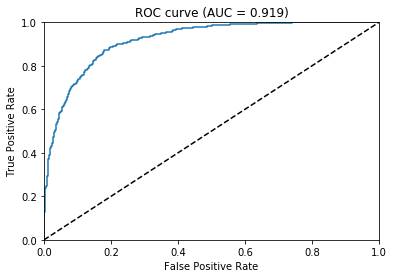

In [43]:
#the ROCAUC score is now 98.0 witht eh 2080 split compared to the 40 60 from before 
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(metrics.roc_auc_score(testY, preds)))

In [44]:
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(testY, preds)
for i in range(0,len(recall), 15):
    print("Threshold {0}, recall = {1}, precision = {2}".format(thresholds[i], recall[i], precision[i]))

Threshold 0.0020034145563840866, recall = 1.0, precision = 0.3333333333333333
Threshold 0.0021358937956392765, recall = 0.9981515711645101, precision = 0.3358208955223881
Threshold 0.002323199063539505, recall = 0.9981515711645101, precision = 0.3389830508474576
Threshold 0.002520115114748478, recall = 0.9981515711645101, precision = 0.34220532319391633
Threshold 0.0027413158677518368, recall = 0.9981515711645101, precision = 0.345489443378119
Threshold 0.003015371970832348, recall = 0.9981515711645101, precision = 0.3488372093023256
Threshold 0.003181140637025237, recall = 0.9981515711645101, precision = 0.3522504892367906
Threshold 0.003510245820507407, recall = 0.9981515711645101, precision = 0.3557312252964427
Threshold 0.003837207332253456, recall = 0.9981515711645101, precision = 0.3592814371257485
Threshold 0.004058527760207653, recall = 0.9963031423290203, precision = 0.36223118279569894
Threshold 0.004271646495908499, recall = 0.9963031423290203, precision = 0.3659198913781398

AUC Score (Test): 0.817138


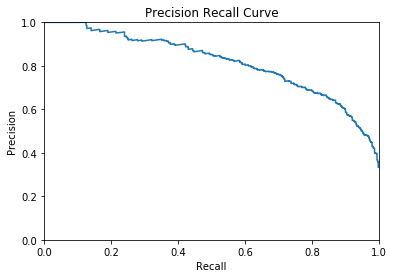

In [45]:
#draw precison recall curve
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(testY, preds)
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
print("AUC Score (Test): %f" % metrics.average_precision_score(testY, preds))
plt.show()

[0.97646505 0.99650395 0.47860256 0.93277997 0.01484604]
541 1459
[807. 111.  51.  43.  31.  30.  20.  13.  16.  16.  16.  15.  10.  17.
   7.   4.   9.  10.  11.   6.   6.  10.   5.   5.   8.   4.   6.  10.
   6.   7.   4.   4.  12.   8.   7.   5.   4.   5.   6.   4.   7.   3.
   9.   8.  10.   7.   8.  13.  10.  15.]
[ 12  12   6   6   4   3   6   3   2   1   5   2   6   2   5   4   2   4
   8   2   9   3   5   4   3   5   7   4   5   2   5   5   3   5   8   3
   7   9  10   6   7   6   9  14  18  16  26  20  49 105]


(0, 350)

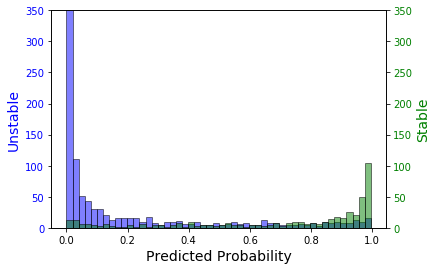

In [46]:
# Histogram:
bins = 50
Stable=preds[np.where(testY==1)]
print(Stable[:5][:])
Unstable=preds[np.where(testY==0)]
print(Stable.size, Unstable.size)


fig, ax1 = plt.subplots()
n, bins, pathces = ax1.hist(Unstable, bins, alpha=0.5, label='No', color='blue', edgecolor = "black")
print(n)
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('Unstable',  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    


ax2 = ax1.twinx()
n, bins , patches = ax2.hist(Stable, bins, alpha=0.5, label='Yes',color='green', edgecolor = "black")
print(n.astype(int))
ax2.set_ylabel('Stable', fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')
    
    
#ax1.set_ylim(ax2.get_ylim())
ax1.set_ylim([0,350]) # goes up to ~4300
ax2.set_ylim([0,350]) # goes up to ~2100

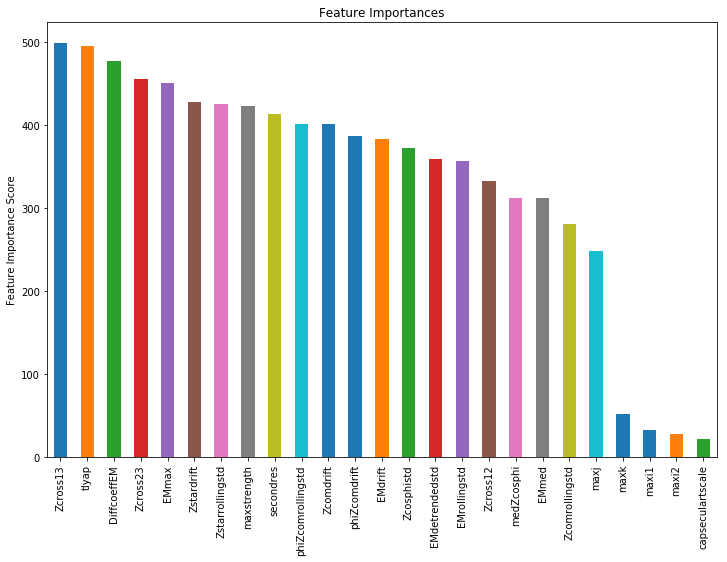

In [47]:
# feature importances
feat_imp = pd.Series(best_xgbc.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances', figsize=(12,8))
plt.ylabel('Feature Importance Score')
plt.show()

In [21]:
import dill
import sys
dill.dump([best_xgbc, features], open(datapath+"../models/ressummaryfeaturesxgb_resonant.pkl", "wb"))